In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.ticker as mtick
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

In [3]:
df_filtered = df_dropped[['isGoal', 'distanceToGoal', 'angleWithGoal']]
df_filtered.head(1)

,isGoal,distanceToGoal,angleWithGoal
0,0.0,34.525353,10.00798


In [4]:
df_filtered.columns

Index(['isGoal', 'distanceToGoal', 'angleWithGoal'], dtype='object')

XGBOOST BASELINE 

In [5]:
train, test = train_test_split(df_filtered, test_size=0.2, random_state=42)
print(train.shape)
print(test.shape)

x = train[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y = train['isGoal'].to_numpy()

x_test = test[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y_test = test['isGoal'].to_numpy()

(246967, 3)
(61742, 3)


In [6]:
x, y = RandomUnderSampler().fit_resample(x, y)

In [7]:
print(x.shape)
print(y.shape)
print(x_test.shape)
print(y_test.shape)

(45216, 2)
(45216,)
(61742, 2)
(61742,)


In [8]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x, y)
y_pred_test = xgb_classifier.predict(x_test)
score_prob = xgb_classifier.predict_proba(x_test)[:, 1]

In [9]:
accuracy_score(y_test, y_pred_test)

0.6220077095008261

0.2574137711594756


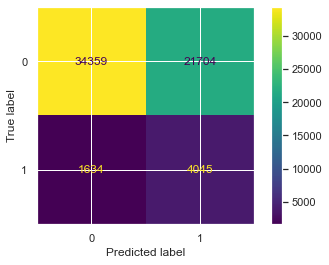

In [10]:
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)
print(f1_score(y_test, y_pred_test))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

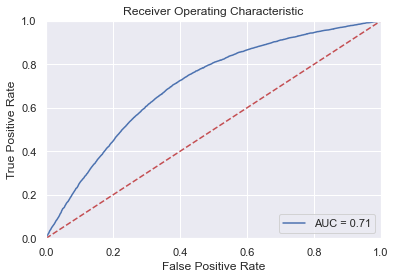

In [11]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
def prepare_goal_rate(y_array, score_prob):
    built_array = []
    index_array = list(range(0, 100, 5))
    total_goal = 0
    goal_array = []
    for i in range(0, 100, 5) :
        sub_y_array = y_array[np.logical_and(score_prob >= np.percentile(score_prob, i), score_prob < np.percentile(score_prob, i+5))]
        goals = np.count_nonzero(sub_y_array)
        shots = sub_y_array.size - goals
        sub_final = goals / (shots + goals)
        goal_array.append(goals)
        total_goal = total_goal + goals
        built_array.append(sub_final*100)
    return built_array, index_array, goal_array, total_goal

In [13]:
def create_goal_rate_plot(index_array, built_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, built_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['XGboost baseline'])
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=12)
    plt.show()

In [14]:
def compute_cumulative(goal_array, total_goal):
    cumulative_array = []
    last_elem = 0
    for i in np.flip(goal_array):
        if total_goal != 0:
            current = i / total_goal*100 + last_elem
        else:
            current = last_elem
        cumulative_array.append(current)
        
        last_elem = current
    return cumulative_array

In [15]:
def create_cumulative_plot(index_array, cumulative_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, cumulative_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['XGboost baseline'])
    plt.title("Cumulative % of goal")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.show()

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


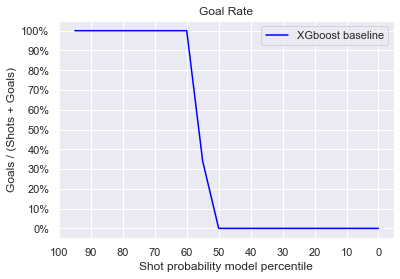

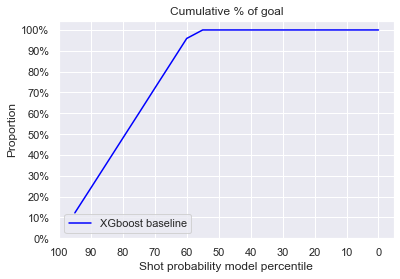

In [16]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_pred_test, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

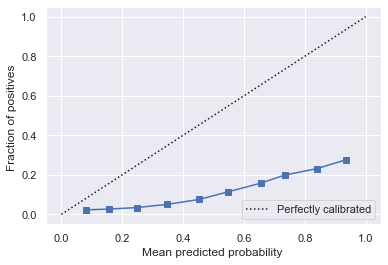

In [17]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

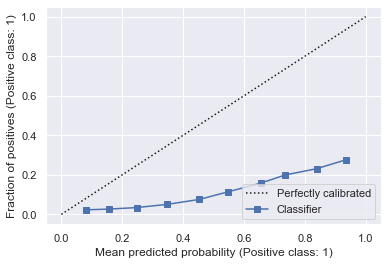

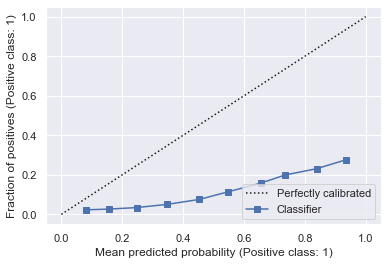

In [18]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob, n_bins = 10).plot()
plt.show()

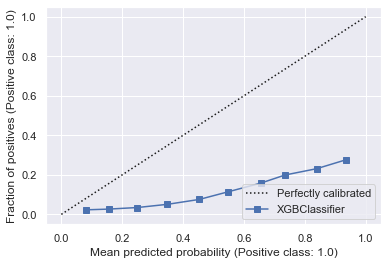

In [19]:
disp = CalibrationDisplay.from_estimator(xgb_classifier, x_test, y_test, n_bins = 10)
plt.show()

XGBOOST USING MORE FEATURES

In [20]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

In [21]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308709 entries, 0 to 327260
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   gameId                 308709 non-null  int64  
 1   season                 308709 non-null  int64  
 2   gameType               308709 non-null  object 
 3   dateTime               308709 non-null  object 
 4   team                   308709 non-null  object 
 5   eventIdx               308709 non-null  int64  
 6   event                  308709 non-null  object 
 7   isGoal                 308709 non-null  float64
 8   shotType               308679 non-null  object 
 9   description            308709 non-null  object 
 10  period                 308709 non-null  int64  
 11  periodType             308709 non-null  object 
 12  periodTime             308709 non-null  object 
 13  secondsSinceStart      308709 non-null  int64  
 14  strength               28287 non-nul

In [22]:
df_dropped = df_dropped[['isGoal', 'speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType']]

In [23]:
dummy_object = pd.get_dummies(df_dropped[['strength', 'shotType', 'prevEvent']])
print(dummy_object)

        strength_Even  strength_Power Play  strength_Short Handed  \
0                   0                    0                      0   
1                   0                    0                      0   
2                   0                    0                      0   
3                   0                    0                      0   
4                   0                    0                      0   
...               ...                  ...                    ...   
327256              0                    0                      0   
327257              0                    0                      0   
327258              0                    0                      0   
327259              0                    0                      0   
327260              1                    0                      0   

        shotType_Backhand  shotType_Deflected  shotType_Slap Shot  \
0                       0                   0                   0   
1                       0        

In [24]:
df_dropped = df_dropped.merge(dummy_object, left_index=True, right_index=True)
df_dropped.head(1)

,isGoal,speedOfChangeOfAngle,speed,changeOfAngleFromPrev,rebound,distanceFromPrev,secondsSincePrev,prevAngleWithGoal,prevY,prevX,...,shotType_Wrist Shot,prevEvent_Blocked Shot,prevEvent_Faceoff,prevEvent_Giveaway,prevEvent_Goal,prevEvent_Hit,prevEvent_Missed Shot,prevEvent_Penalty,prevEvent_Shot,prevEvent_Takeaway
0,0.0,0.0,14.025066,0.0,False,154.275727,11.0,98.365886,-34.0,94.0,...,1,0,0,0,0,1,0,0,0,0


In [25]:
df_dropped = df_dropped.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

In [26]:
df_dropped.shape

(308709, 36)

In [27]:
train, test = train_test_split(df_dropped, test_size=0.2, random_state=42)
print(train.shape)
print(test.shape)

x = train[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y = train['isGoal'].to_numpy()

x_test = test[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y_test = test['isGoal'].to_numpy()

(246967, 36)
(61742, 36)


In [28]:
x, y = RandomUnderSampler().fit_resample(x, y)

In [32]:
print(x.shape)
print(y.shape)
print(x_test.shape)
print(y_test.shape)

(45216, 2)
(45216,)
(61742, 2)
(61742,)


In [30]:
non_goal_ratio = len(y[y == 0])/len(y)
goal_ratio = 1 - non_goal_ratio
print(non_goal_ratio)
print(goal_ratio)

0.5
0.5


In [31]:
non_goal_ratio = len(y_test[y_test == 0])/len(y_test)
goal_ratio = 1 - non_goal_ratio
print(non_goal_ratio)
print(goal_ratio)

0.9080204722879077
0.09197952771209228


In [19]:
params = {
 'learning_rate' : [0.05,0.10],
 'max_depth' : [ 3, 4, 5],
 'min_child_weight' : [ 1, 3],
 'gamma': [ 0.0, 0.1, 0.2],
 'colsample_bytree' : [ 0.3, 0.4, 0.5], 
    'n_estimators': [300,400,500], 
    'booster':['gbtree','gblinear']
}

In [34]:
xgb_classifier = xgb.XGBClassifier()
#xgb = RandomizedSearchCV(xgb_classifier, param_distributions = params, n_iter=5,scoring='roc_auc', cv =5)
xgb_classifier.fit(x, y)#, eval_metric='rmse')
y_pred = xgb_classifier.predict(x_test)
score_prob = xgb_classifier.predict_proba(x_test)[:, 1]

In [76]:
pd.DataFrame(xgb.cv_results_)

AttributeError: module 'xgboost' has no attribute 'cv_results_'

In [26]:
xgb.best_params_

{'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.4,
 'booster': 'gblinear'}

In [79]:
xgb.best_score_

AttributeError: module 'xgboost' has no attribute 'best_score_'

In [36]:
accuracy_score(y_test, y_pred)

0.6137151371837647

0.25510650259229184


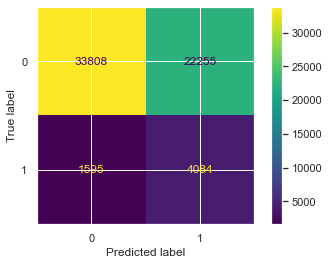

In [38]:
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)
print(f1_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

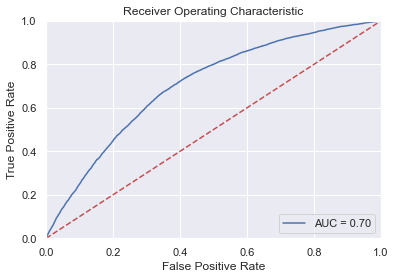

In [39]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


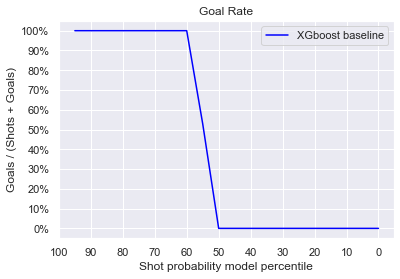

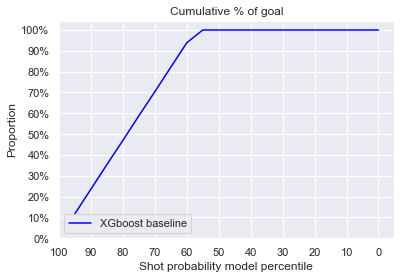

In [40]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

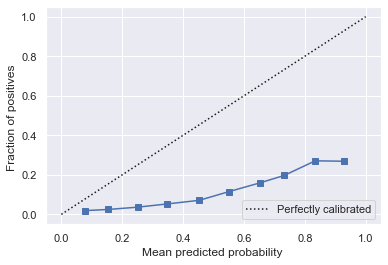

In [41]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

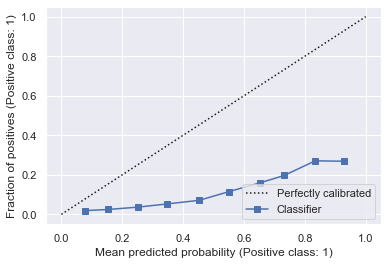

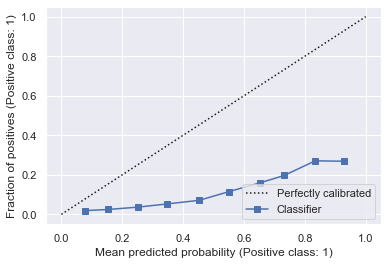

In [42]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob, n_bins = 10).plot()
plt.show()

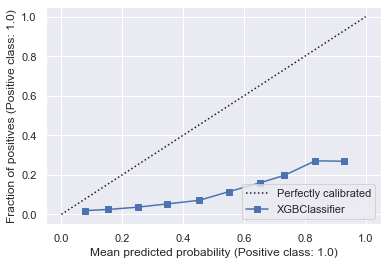

In [44]:
disp = CalibrationDisplay.from_estimator(xgb_classifier, x_test, y_test, n_bins = 10)
plt.show()